# 1. Loading libraries & last notebook

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import copy 
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from matplotlib.colors import ListedColormap
from neural_network import *
# Setting font parameters for graphs
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['font.serif'] = 'Roboto'
plt.rcParams['font.monospace'] = 'Roboto Mono'
plt.rcParams['font.size'] = 14


In [18]:
def plot_decision_boundary(X,parameters_trained, grid_unit = 0.001):
    """
    Plots the decision boundary from the trained model.
    
    Args:
        X (np.array): the array containing the data.
        parameters_trained (dict): parameters defining the model.
        grid_unit (float): the size of the grid unit.
    """
    # Visualizing the dataset:
    plt.figure(figsize=(7, 5), dpi=75)
    colors = {0: '#396ad3', 1: '#f09e1f'}
    cmap = ListedColormap([colors[val] for val in sorted(colors.keys())])

    min1, max1 = X[0,:].min()-1, X[0, :].max()+1
    min2, max2 = X[1,:].min()-1, X[1, :].max()+1

    x1grid = np.arange(min1, max1, grid_unit)
    x2grid = np.arange(min2, max2, grid_unit)

    xx, yy = np.meshgrid(x1grid, x2grid)

    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    grid = np.hstack((r1,r2)).T

    yhat = predict(grid, parameters_trained)

    zz = yhat.reshape(xx.shape)
    colors_back = {0: '#DAEAF1', 1: '#FFF9CA'}
    cmap_back = ListedColormap([colors_back[val] for val in sorted(colors_back.keys())])
    plt.contourf(xx, yy, zz, cmap=cmap_back)
    
    ax = sns.scatterplot(x=X[0,:],y=X[1,:],c=y[0],s=5,linewidth=0,cmap=cmap)
    beautiful_plot(ax,'Two moons dataset','','',despine=False)
    plt.show()
    return

# 2. Loading the dataset

In [3]:
# Creating the dataset and reshaping.
X,y = make_moons(n_samples=20000,noise=0.12)
X = X.T
y = y.reshape(1,-1)

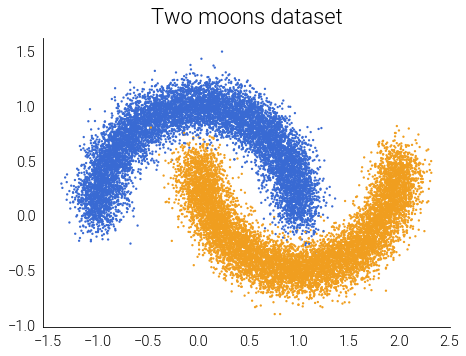

In [13]:
# Visualizing the dataset.
plt.figure(figsize=(7, 5), dpi=75)
colors = {0: '#396ad3', 1: '#f09e1f'}
cmap = ListedColormap([colors[val] for val in sorted(colors.keys())])
ax = sns.scatterplot(x=X[0,:],y=X[1,:],c=y[0],s=5,linewidth=0,cmap=cmap)
beautiful_plot(ax,'Two moons dataset','','')
plt.show()

# 3. Creating a model

In [14]:
np.random.seed(1)
# Defining my neural network as a 4-Layer (3RelU + 1Sigmoid). 
act = ['relu','relu','relu','sigmoid']
parameters = initialize_parameters(X,[32,16,8],y,act=act)

# 4. Gradient batch descent

Cost at iteration 1: 0.6596
Cost at iteration 20: 0.4474


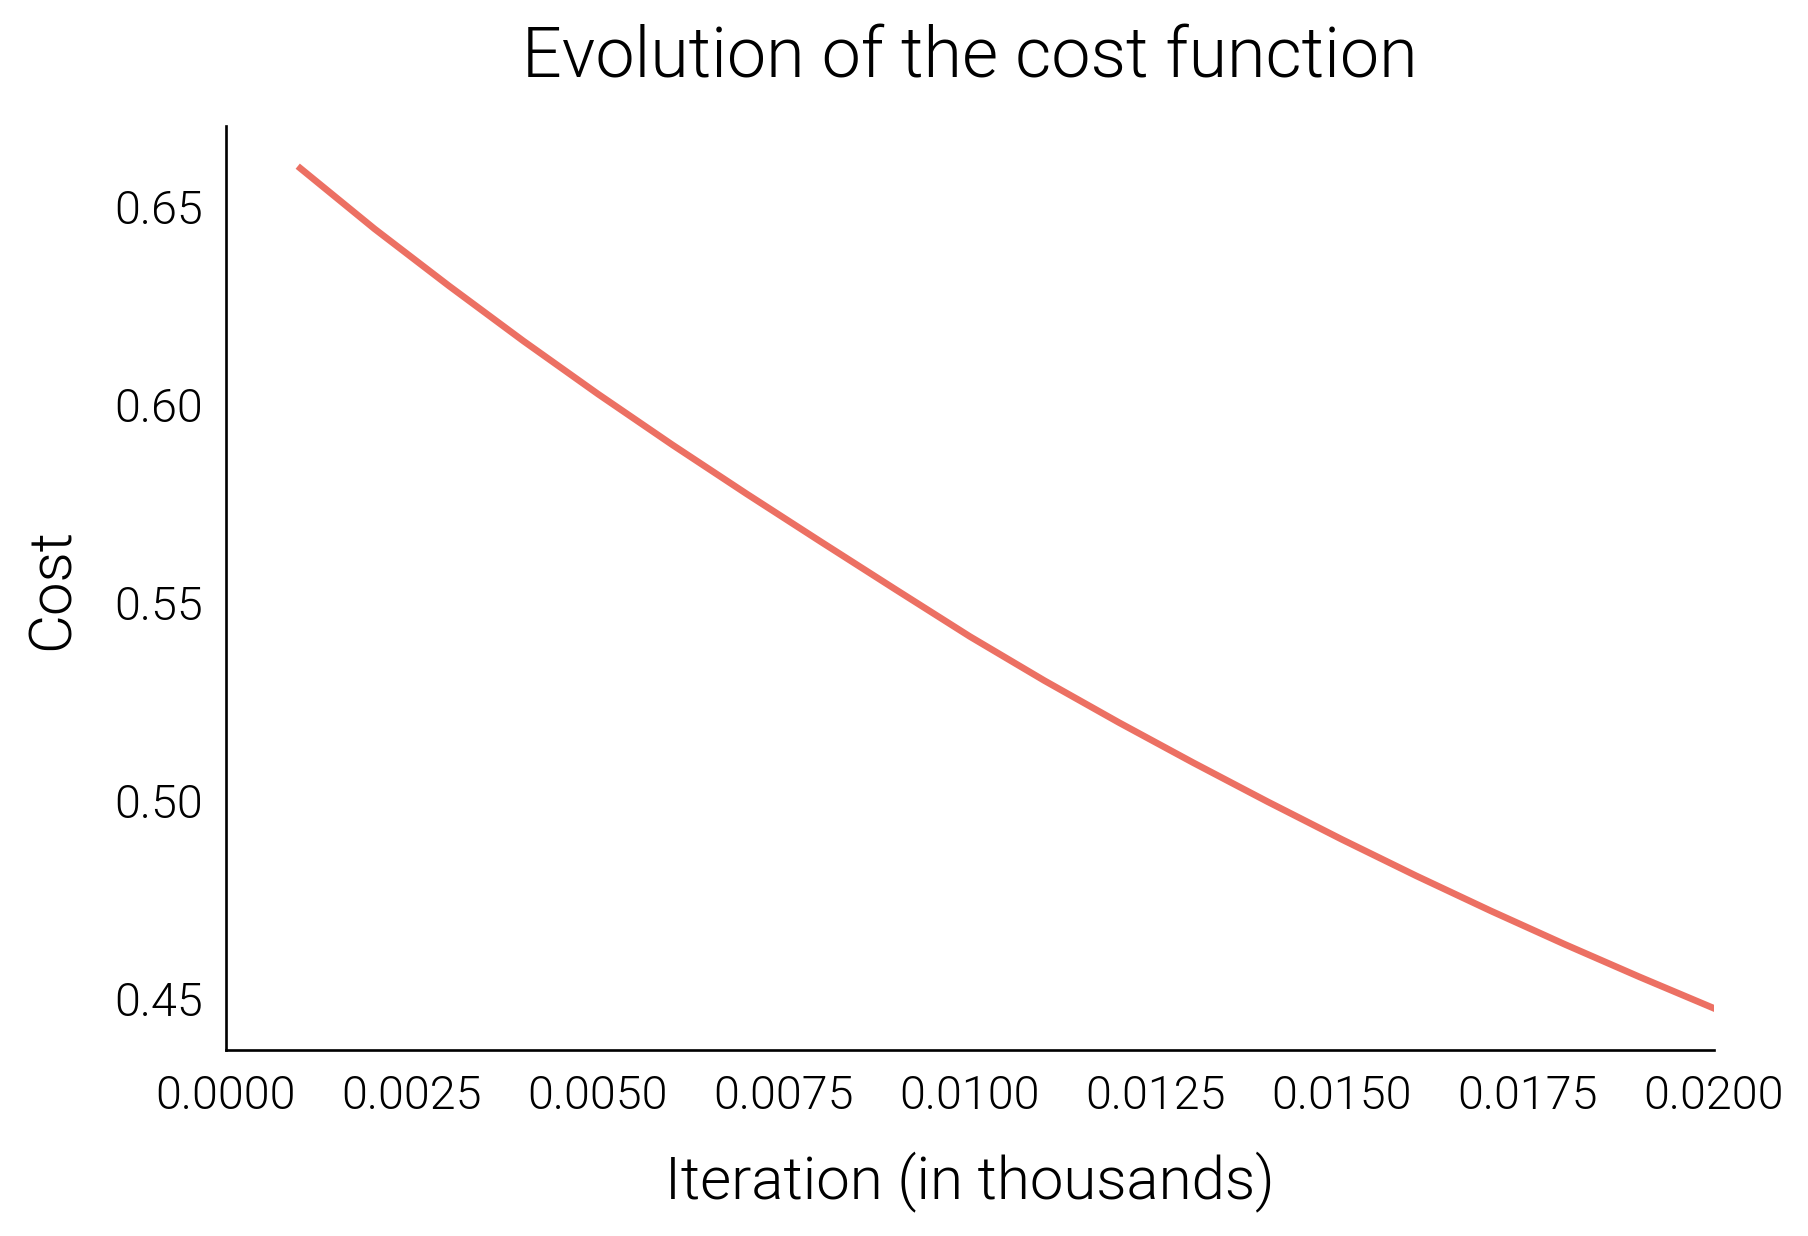

CPU times: user 3.98 s, sys: 173 ms, total: 4.16 s
Wall time: 638 ms


In [15]:
%%time
# Training the model on the train dataset
costs_batch, trained_batch = gradient_descent(X,y,parameters, learning_rate=0.1,iterations= 20)

In [16]:
# Testing model with train dataset
predictions = predict(X,trained_batch)
acc = np.sum(y == predictions)/y.shape[1]*100
print(f'Our batch gradient descent model has a train accuracy of {acc:.2f}%.')

Our batch gradient descent model has a train accuracy of 86.22%.


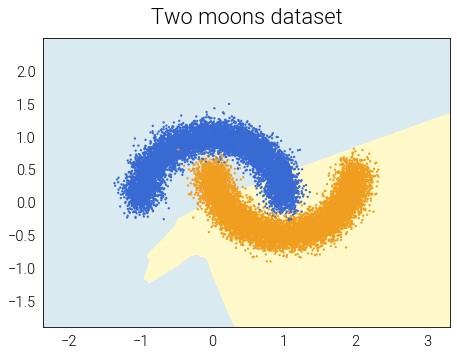

In [19]:
# Visualizing the dataset:
plot_decision_boundary(X,trained_batch,grid_unit=0.005)

# 5. Gradient mini-batch descent
Implementing mini-batch gradient descent will only require a new function and a slight change to the function gradient_descent.

In [24]:
def generate_mini_batches(X,Y,mini_batch_size,seed=0):
    """
    This function divides the dataset into random minibatches.
    
    Args:
        X (np.array): the array containing the data.
        Y (np.array): the array containing the target.
        mini_batch_size (int): the size of a mini-batch.
    """
    np.random.seed(seed)
    m = Y.shape[1]
    mini_batches = []
    
    # Shuffling the dataset to generate minibatches
    permutation = list(np.random.permutation(m))
    random_X = X[:, permutation]
    random_Y = Y[:, permutation].reshape((1,-1))
    n_batches = math.floor(m/mini_batch_size)
    
    for k in range(0,n_batches):
        mini_random_X = random_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_random_Y = random_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        
        mini_batch = (mini_random_X, mini_random_Y)
        mini_batches.append(mini_batch)
        
    # We take care now of the last batch if it's not complete
    if m%mini_batch_size != 0:
        mini_random_X = random_X[:,(n_batches)*mini_batch_size:]
        mini_random_Y = random_Y[:,(n_batches)*mini_batch_size:]
        
        mini_batch = (mini_random_X, mini_random_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches

In [38]:
def gradient_descent_mini(X,Y, parameters_, learning_rate, epochs, lambd=0, mini_batch_size=None):
    """
    Performs mini-batch gradient descent with the hyperparameters of the input,
    and returns the trained parameters as well as the cost evolution.
    
    Args:
        X (np.array): training values of the independant variables X.
        Y (np.array): traning values of the target variable Y. 
        parameters_ (dict): values defining the initial model.
        learning_rate (float): the learning rate alpha used in the algorithm.
        epochs (int): number of iterations we want to perform gradient descent
        mini_batch_size (int): size of the mini-batches.
        
    Returns:
        cost (np.array): list of the cost function through each iteration.
        parameters (dict): dictionary containing the trained model:
            W1 -- matrix with weights from layer 1. 
            b1 -- vector with biases from layer 1.
            ......................................
            W_max -- matrix of weights from last layer. 
            b_max -- vector of biases from last layer.
    """
    m = Y.shape[1]
    seed = 10
    parameters = copy.deepcopy(parameters_)
    act = parameters['act']
    cost = []
    
    # Computing initial cost
    AL, cache = forward_propagation(X, parameters)
    cost.append(compute_loss(AL,Y, parameters, lambd))
    print(f"Initial cost: {np.squeeze(cost[-1]):.4f}")

    # Gradient descent
    for i in range(epochs):
        seed = seed +1
        
        # Generating mini-batches
        if mini_batch_size == None:
            # if None, create one batch will all the data
            mini_batches = [(X,Y)]
        else:
            # else, create random mini-batches
            mini_batches = generate_mini_batches(X,Y,mini_batch_size,seed)
        
        for minibatch_X,minibatch_Y in mini_batches:
 
            # forward prop
            AL, cache = forward_propagation(minibatch_X, parameters)
                
            #backward prop
            grads = backward_prop(cache, parameters, minibatch_Y)

            # descent
            parameters = update_parameters(parameters,grads,learning_rate,lambd,m)
    
        cost.append(compute_loss(AL,minibatch_Y, parameters, lambd))
        
        # Print the cost every 500 epochs
        if (i == 0 or (i+1) % 500 == 0 or i == epochs - 1):
            print(f"Cost at epoch {i+1}: {np.squeeze(cost[-1]):.4f}")
    
    # Plotting the cost function
    plt.figure(figsize=(8,3),dpi=1200/5)
    iterations_list = np.array(range(0,epochs+1))
    ax = sns.lineplot(y=np.squeeze(cost),x=iterations_list,linewidth = 2, color = '#ec7063')
    plt.xlim([0, np.max(iterations_list)])
    beautiful_plot(ax,'Evolution of the cost function','Iteration (in thousands)','Cost',name='cost')
    plt.show()
    return cost, parameters

Initial cost: 0.6596
Cost at epoch 1: 0.4893
Cost at epoch 20: 0.0073


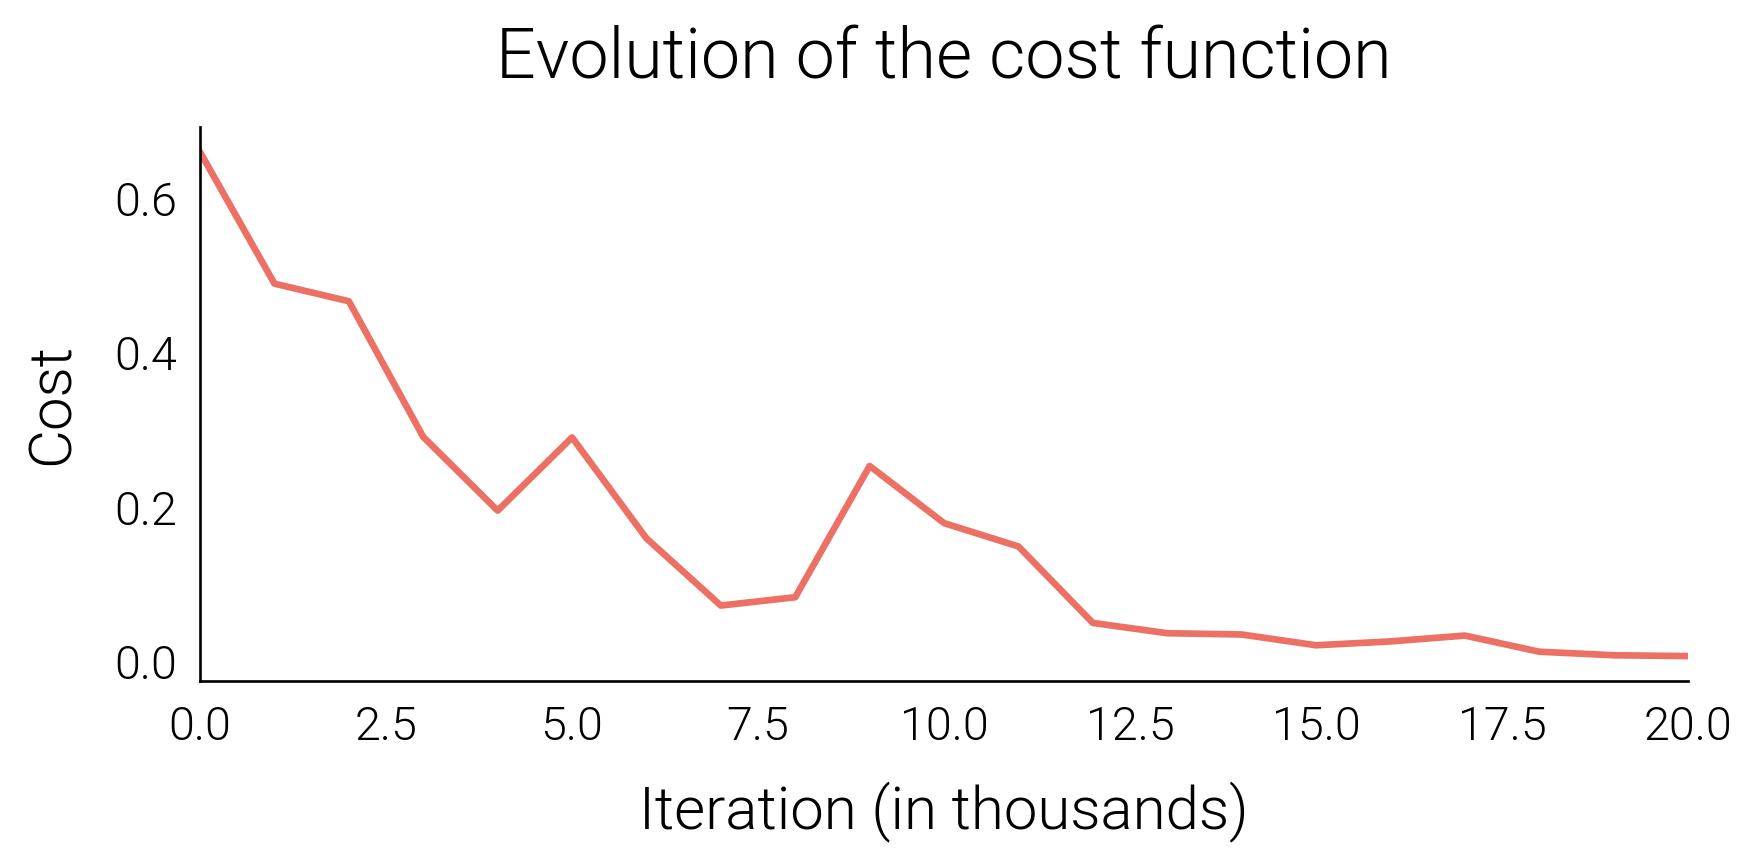

CPU times: user 10.8 s, sys: 139 ms, total: 10.9 s
Wall time: 1.44 s


In [39]:
%%time
# Training the model on the train dataset
costs_mini, trained_mini = gradient_descent_mini(X,y,parameters, learning_rate=0.01,epochs= 20, mini_batch_size=64)

In [40]:
# Testing model with train dataset
predictions = predict(X,trained_mini)
acc = np.sum(y == predictions)/y.shape[1]*100
print(f'Our mini-batch gradient descent model has a train accuracy of {acc:.2f}%.')

Our mini-batch gradient descent model has a train accuracy of 99.56%.


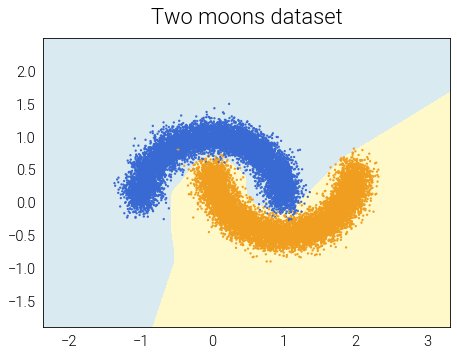

In [41]:
# Visualizing the dataset:
plot_decision_boundary(X,trained_mini,grid_unit=0.005)

# 6. Adam's algorithm
The implementation of Adam's algorithm is a bit more complex, we need to initialize the moments and modify the update of the parameters.

In [42]:
def initialize_adam(parameters):
    """
    Initializes the dictionaries for the first and second momentum
    used in Adam's optimization of mini-batch gradient descent.
    
    Args:
        parameters (dict): parameters defining the model.
    Returns:
        v (dict) and s (dict): zero dictionaries. 
    """
    layers = int((len(parameters.keys())-1)/2)
    v = {}
    s = {}
    for layer in range(1,layers+1):
        v['dW'+str(layer)] = np.zeros(parameters['W'+str(layer)].shape)
        v['db'+str(layer)] = np.zeros(parameters['b'+str(layer)].shape)
        
        s['dW'+str(layer)] = np.zeros(parameters['W'+str(layer)].shape)
        s['db'+str(layer)] = np.zeros(parameters['b'+str(layer)].shape)
        
    return v,s

In [43]:
def update_parameters_adam(parameters,grads, learning_rate, v, s, t, beta1, beta2, epsilon = 1e-8):
    """
    Updates the parameters according to the gradient descent algorithm,
    but with Adam's optimization. 
    
    Args:
        X (np.array): the array containing the data.
        parameters (dict): parameters defining the model.
        grads (dict): the gradients of the parameters.
        learning_rate(float): the value alpha for gradient descent.
        v (dict): the current values of the first moment.
        s (dict): the current values of the second moment.
        beta1 (float): the parameter beta of the first moment.
        beta2 (float): the parameter beta of the second moment.
        
    Returns:
        tuple
            A tuple containing the following two objects:
            - parameters : dict
                The parameters of the model updated.
            - v : dict
                The new values of the first moment.
            - s : dict
                The new values of the second moment.
    """
    v_corrected = {}
    s_corrected = {}
    for l in range(1,int((len(parameters.keys())-1)/2)+1):
        v['dW'+str(l)] = beta1*v['dW'+str(l)] + (1-beta1)*grads['dW'+str(l)]
        v['db'+str(l)] = beta1*v['db'+str(l)] + (1-beta1)*grads['db'+str(l)]
        v_corrected["dW" + str(l)] = v["dW" + str(l)]/(1-beta1**t)
        v_corrected["db" + str(l)] = v["db" + str(l)]/(1-beta1**t)
        
        s['dW'+str(l)] = beta2*s['dW'+str(l)] + (1-beta2)*np.square(grads['dW'+str(l)])
        s['db'+str(l)] = beta2*s['db'+str(l)] + (1-beta2)*np.square(grads['db'+str(l)])
        s_corrected["dW" + str(l)] = s["dW" + str(l)]/(1-beta2**t) 
        s_corrected["db" + str(l)] = s["db" + str(l)]/(1-beta2**t)         
        #print(np.max(learning_rate*v_corrected['dW'+str(l)]/(epsilon+np.sqrt(s_corrected['dW'+str(l)]))))
        #print(np.max(learning_rate*v_corrected['db'+str(l)]/(epsilon+np.sqrt(s_corrected['db'+str(l)]))))
        #print('updating layer ', str(layer))
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate*v_corrected['dW'+str(l)]/(epsilon+np.sqrt(s_corrected['dW'+str(l)]))
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate*v_corrected['db'+str(l)]/(epsilon+np.sqrt(s_corrected['db'+str(l)]))
    
    return parameters, v, s

In [44]:
def gradient_descent_adam(X,Y, parameters_, learning_rate, epochs, lambd=0, mini_batch_size=None, beta1=0.9, beta2=0.999, decay = False, decay_rate = 1, decay_interval = 5):
    """
    Performs mini-batch gradient descent with Adam's optimization,
    and returns the trained parameters as well as the cost evolution.
    
    Args:
        X (np.array): training values of the independant variables X.
        Y (np.array): traning values of the target variable Y. 
        parameters_ (dict): values defining the initial model.
        learning_rate (float): the learning rate alpha used in the algorithm.
        epochs (int): number of iterations we want to perform gradient descent
        mini_batch_size (int): size of the mini-batches.
        beta1 (float): the parameter beta of the first moment.
        beta2 (float): the parameter beta of the second moment.
        decay (boolean): 1 if you want to perform learning rate decay.
        decay_rate (float): the learning decay rate.
        decay_interval (int): the number of iterations a learning rate holds before decaying
        
    Returns:
        cost (np.array): list of the cost function through each iteration.
        parameters (dict): dictionary containing the trained model:
            W1 -- matrix with weights from layer 1. 
            b1 -- vector with biases from layer 1.
            ......................................
            W_max -- matrix of weights from last layer. 
            b_max -- vector of biases from last layer.
    """
    m = Y.shape[1]
    seed = 10
    parameters = copy.deepcopy(parameters_)
    act = parameters['act']
    cost = []
    
    #computing initial cost
    AL, cache = forward_propagation(X, parameters)
    cost.append(compute_loss(AL,Y, parameters, lambd))
    print(f"Initial cost: {np.squeeze(cost[-1]):.4f}")
    
    # Initializing adam
    t = 0
    learning_rate_0 = copy.deepcopy(learning_rate)
    v,s = initialize_adam(parameters)
    
    # Gradient descent
    for i in range(epochs):
        seed = seed +1
        #generating mini_batches
        if mini_batch_size == None:
            mini_batches = [(X,Y)]
        else:
            mini_batches = generate_mini_batches(X,Y,mini_batch_size,seed)
        
        for minibatch_X,minibatch_Y in mini_batches:
            # forward prop
            AL, cache = forward_propagation(minibatch_X, parameters)
                
            #backward prop
            grads = backward_prop(cache, parameters, minibatch_Y)
            # descent
            t = t+1
            parameters, v, s = update_parameters_adam(parameters,grads,learning_rate, v, s, t, beta1, beta2)
            
        # Print the cost every 100 epochs
        cost.append(compute_loss(AL,minibatch_Y, parameters, lambd))
        if (i == 0 or (i+1) % 500 == 0 or i == epochs - 1):
            print(f"Cost at epoch {i+1}: {np.squeeze(cost[-1]):.4f}")
            
        if decay ==True:
            learning_rate = 1/(1+decay_rate*math.floor(i/decay_interval))*learning_rate_0
            
    # Plotting cost
    plt.figure(figsize=(8,3),dpi=1200/5)
    iterations_list = np.array(range(0,epochs+1))
    ax = sns.lineplot(y=np.squeeze(cost),x=iterations_list,linewidth = 2, color = '#ec7063')
    plt.xlim([0, np.max(iterations_list)])
    beautiful_plot(ax,'Evolution of the cost function','Iteration','Cost',name='cost')
    plt.show()
    return cost, parameters

Initial cost: 0.6596
Cost at epoch 1: 0.0154
Cost at epoch 20: 0.0010


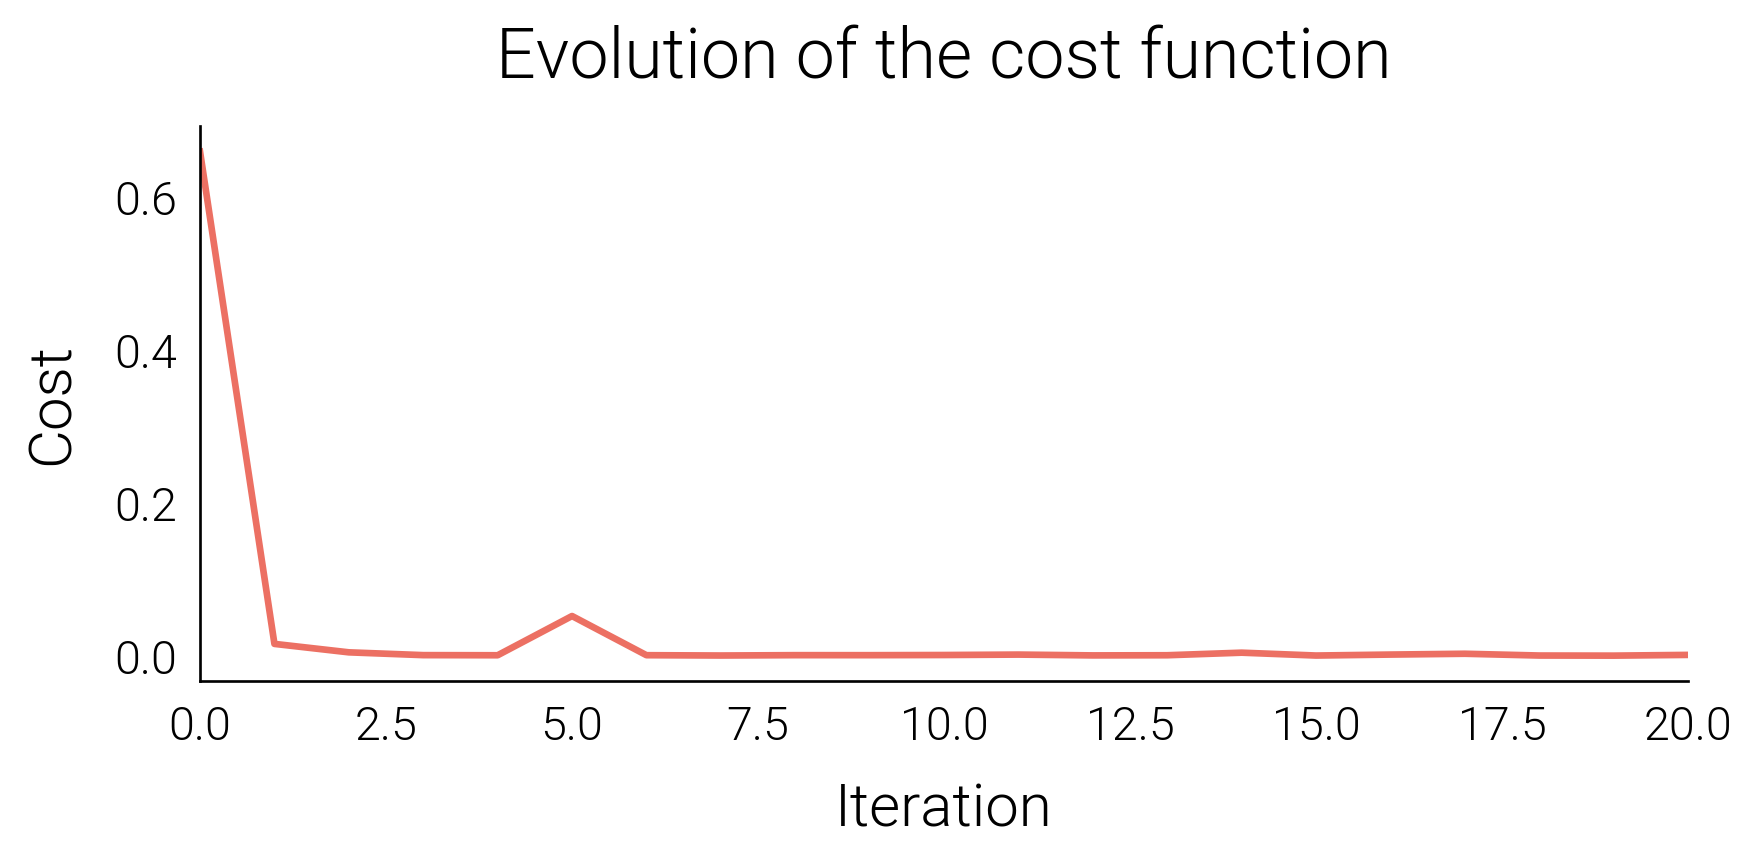

CPU times: user 15.2 s, sys: 120 ms, total: 15.3 s
Wall time: 1.98 s


In [45]:
%%time
# Training the model on the train dataset
costs_adam, trained_adam = gradient_descent_adam(X,y,parameters, learning_rate=0.01,epochs= 20, mini_batch_size=64,decay=True)

In [46]:
# Testing model with train dataset
predictions = predict(X,trained_adam)
acc = np.sum(y == predictions)/y.shape[1]*100
print(f'Our adam gradient descent with decay model has a train accuracy of {acc:.2f}%.')

Our adam gradient descent with decay model has a train accuracy of 99.76%.


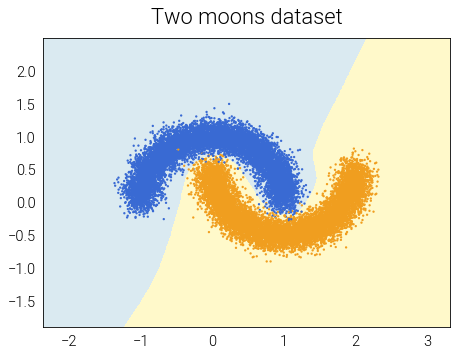

In [47]:
plot_decision_boundary(X,trained_adam,grid_unit=0.005)

# 7. Comparing the three techniques

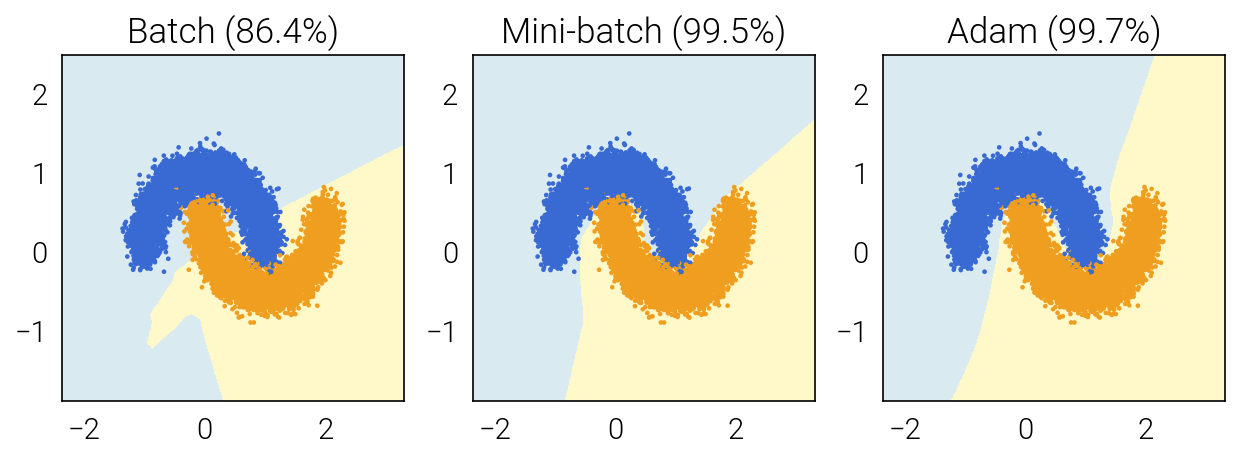

In [48]:
grid_unit = 0.01

fig, axs = plt.subplots(1,3,figsize=(10, 3), dpi=150)    
i = 0
titles = ['Batch (86.4%)','Mini-batch (99.5%)','Adam (99.7%)']
for parameters_trained in [trained_batch, trained_mini, trained_adam]:
        
    # Visualizing the dataset:
    colors = {0: '#396ad3', 1: '#f09e1f'}
    cmap = ListedColormap([colors[val] for val in sorted(colors.keys())])

    min1, max1 = X[0,:].min()-1, X[0, :].max()+1
    min2, max2 = X[1,:].min()-1, X[1, :].max()+1

    x1grid = np.arange(min1, max1, grid_unit)
    x2grid = np.arange(min2, max2, grid_unit)

    xx, yy = np.meshgrid(x1grid, x2grid)

    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    grid = np.hstack((r1,r2)).T

    yhat = predict(grid, parameters_trained)

    zz = yhat.reshape(xx.shape)
    colors_back = {0: '#DAEAF1', 1: '#FFF9CA'}
    cmap_back = ListedColormap([colors_back[val] for val in sorted(colors_back.keys())])
    axs[i].contourf(xx, yy, zz, cmap=cmap_back)
    ax = sns.scatterplot(x=X[0,:],y=X[1,:],c=y[0],s=5,linewidth=0,cmap=cmap, ax = axs[i])
    beautiful_plot(ax,'Two moons dataset','','',despine=False)
    axs[i].set_title(titles[i])
    i+=1
plt.savefig('../figures/compare_boundary.png')
plt.show()


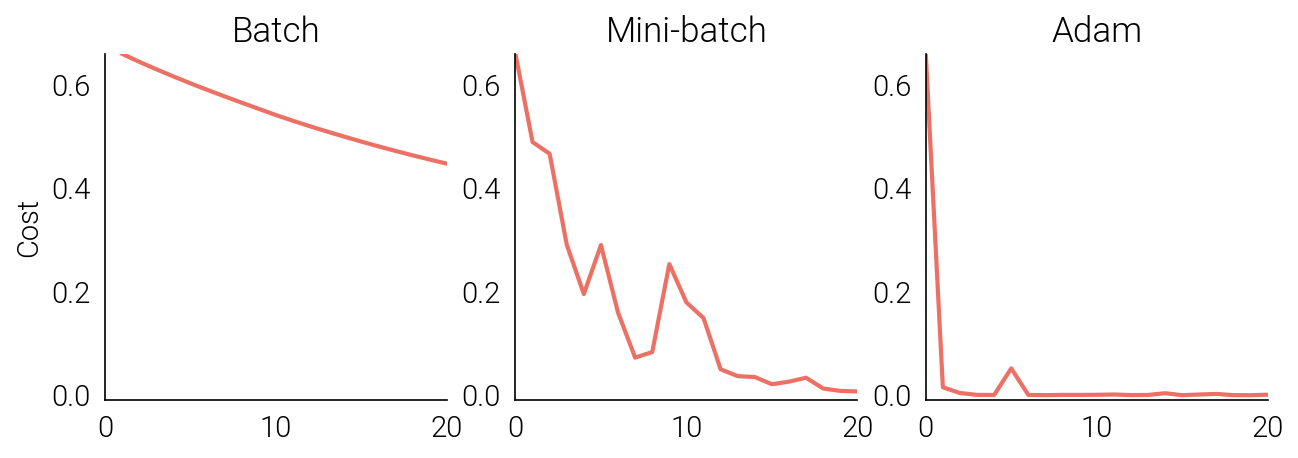

In [49]:
iterations_list = np.array(range(1,20+1))
fig, axs = plt.subplots(1,3,figsize=(10, 3), dpi=150)    
i = 0
titles = ['Batch','Mini-batch','Adam']
for cost in [costs_batch, costs_mini, costs_adam]:

    ax = sns.lineplot(y=np.squeeze(cost),x=iterations_list,linewidth = 2, color = '#ec7063', ax = axs[i]) 
    axs[i].set_ylim([-0.01, np.max(cost)])
    axs[i].set_xlim([0, np.max(iterations_list)])
    beautiful_plot(ax,'','','')
    iterations_list = np.array(range(0,20+1))
    axs[i].set_title(titles[i])

    i = i+1
axs[0].set_ylabel('Cost')
plt.savefig('../figures/compare_training.png')
plt.show()

We can see that adam's algorithm is the fastest to converge, with a big difference in performance. It is also the method that delivers the most optimal model in terms of accuracy.